# Emission trajectories and land use pattern at regional level


In [1]:
import copy
import datatoolbox as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ems_pattern_fun import timeseries_df, pure_emis, timeseries_pattern, stackplot_pattern

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


/Users/firzariany/Documents/datashelf_2rawdata/FAO_2019/Emissions_Land_Use_Land_Use_Total_E_All_Data.csv
0 source reader found and added into "datatoolbox.sources".


In [17]:
sns.set_theme(style="dark")

In [2]:
# configuring the location of local datashelf
dt.admin.change_personal_config()

Please enter your initials:  FR
Please enter path to datashelf:  /Users/firzariany/Documents/datashelf_2


# Checking LULUCF emissions and sequestration across scenarios (Brazil)
Testing done on Brazil
- Old version = SSP1-19-SPA1-V17  
- Low biomass version = SSP1_SPA0_19I_LIRE_LB  
- Baseline scenario = SSP1_26  

## Processing the old version of SSP1_19 (SSP1-19-SPA1-V17), Brazil

In [3]:
# importing sequestration from SSP1_19 old version
seq_invent = dt.findp(source = "IMAGE*", variable = "Emissions|CO2|Land_Use|Carbon_Sequestration", 
                      scenario = 'SSP1-19-SPA1-V17')

seq_tab = dt.getTable(seq_invent.index[0])

In [4]:
# importing net emission from SSP1_19 old version
netemis_invent = dt.findp(variable = "Emissions|CO2|Land_Use", source = "IMAGE*", scenario = 'SSP1-19-SPA1-V17')

netemis_tab = dt.getTable(netemis_invent.index[0])

**Accounting rules**

"Emissions|CO2|Land_Use|Carbon_Sequestration" includes carbon sequestration on managed land, negative and positive. When negative, it contributes to emissions because this negative sequestration is due to forest degradation in the area as a product of past management (accounting period of 75 years), therefore their emissions are considered anthropogenic. Fluxes from burning coal or land cover change are not included (in this negative sequestration), however *fluxes from the negative impact of climate change on forests or continued degradation are included*, which can sometimes lead to negative carbon sequestration.  

"Emissions|CO2|Land_Use" is a total net land use change emissions, meaning that it is a balance between emissions and sequestration. (Net) emissions would be positive when emissions from all (land) categories are bigger than sequestration, on the other hand it would be negative when emissions are lower than sequestration.  

To account for sequestration and emissions separately, we should have some accounting rules:  
- Carbon sequestration = divided into forest degradation (negative sequestration from degradation) and sequestration (positive sequestration)  
- Calculate all emissions from land use and forestry (ems_all) = (net) emissions – positive sequestration  
- Calculate emissions from land use change (ems_luc) = ems_all – negative sequestration from degradation  

In [48]:
def calc_emis_seq(give_seq_tab, give_netemis_tab):
    # create templates for: 1) emission from forest degradation (ems_for_degrade)
    ems_for_degrade = copy.deepcopy(give_seq_tab)
    
    # 2) positive sequestration = seq_tab
    pos_seq = copy.deepcopy(give_seq_tab)

    # pipeline to separate sequestration and emission
    for yr in seq_tab.columns:
        for country in seq_tab.index:
            ems_for_degrade.loc[country, yr] = -1*(lambda x: 0 if x > 0 else x)(give_seq_tab.loc[country, yr])
            pos_seq.loc[country, yr] = (lambda x: 0 if x <= 0 else x)(give_seq_tab.loc[country, yr])
        
    # 3) emissions from land use and forestry (ems_lulucf)
    ems_lulucf = give_netemis_tab + pos_seq
    
    # 4) emission from only land use change (ems_lu_chg)
    ems_lu_chg = ems_lulucf - ems_for_degrade
    
    return ems_for_degrade, pos_seq, ems_lulucf, ems_lu_chg

In [6]:
ems_degrade_19, seq_19, ems_lulucf_19, ems_luc_19 = calc_emis_seq(give_seq_tab=seq_tab, give_netemis_tab=netemis_tab)

**`Comparing negative sequestration due to forest degradation and positive sequestration`**

<AxesSubplot:xlabel='time', ylabel='BRA'>

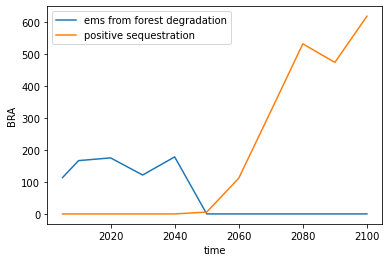

In [7]:
sns.lineplot(x = ems_degrade_19.columns, y = ems_degrade_19.loc["BRA",:], label = "ems from forest degradation")
sns.lineplot(x = seq_19.columns, y = seq_19.loc["BRA",:], label = "positive sequestration")

**`Comparing different sources of emissions`**

<AxesSubplot:xlabel='time', ylabel='BRA'>

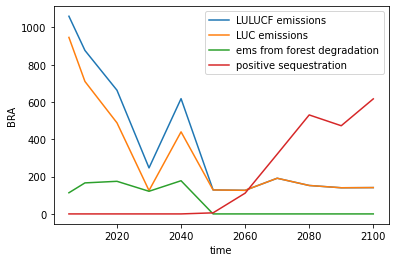

In [8]:
sns.lineplot(x = ems_lulucf_19.columns, y = ems_lulucf_19.loc["BRA",:], label = "LULUCF emissions")
sns.lineplot(x = ems_luc_19.columns, y = ems_luc_19.loc["BRA",:], label = "LUC emissions")
sns.lineplot(x = ems_degrade_19.columns, y = ems_degrade_19.loc["BRA",:], label = "ems from forest degradation")
sns.lineplot(x = seq_19.columns, y = seq_19.loc["BRA",:], label = "positive sequestration")

## Processing baseline scenario (SSP1-26-SPA1-V17), Brazil

In [9]:
# importing sequestration from baseline SSP1_26
seq_base_invent = dt.findp(source="IMAGE*", variable="Emissions|CO2|Land_Use|Carbon_Sequestration", 
                           scenario='SSP1-26-SPA1-V17')

seq_tab_baseline = dt.getTable(seq_base_invent.index[0])

In [10]:
# importing net emission from baseline SSP1_26
netemis_base_invent = dt.findp(variable = "Emissions|CO2|Land_Use", source = "IMAGE*", 
                               scenario = 'SSP1-26-SPA1-V17')

netemis_tab_baseline = dt.getTable(netemis_base_invent.index[0])

<AxesSubplot:xlabel='time', ylabel='BRA'>

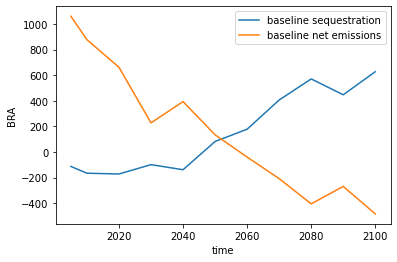

In [11]:
sns.lineplot(x = seq_tab_baseline.columns, y = seq_tab_baseline.loc["BRA",:], label = "baseline sequestration")
sns.lineplot(x = netemis_tab_baseline.columns, y = netemis_tab_baseline.loc["BRA",:], label = "baseline net emissions")

Same accounting principle with the old version

In [12]:
ems_degrade_base, seq_base, ems_lulucf_base, ems_luc_base = calc_emis_seq(give_seq_tab=seq_tab_baseline, give_netemis_tab=netemis_tab_baseline)

**`Comparing different sources of emissions under baseline scenarios`**

<AxesSubplot:xlabel='time', ylabel='BRA'>

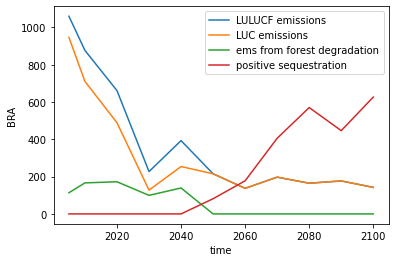

In [13]:
sns.lineplot(x = ems_lulucf_base.columns, y = ems_lulucf_base.loc["BRA",:], label = "LULUCF emissions")
sns.lineplot(x = ems_luc_base.columns, y = ems_luc_base.loc["BRA",:], label = "LUC emissions")
sns.lineplot(x = ems_degrade_base.columns, y = ems_degrade_base.loc["BRA",:], label = "ems from forest degradation")
sns.lineplot(x = seq_base.columns, y = seq_base.loc["BRA",:], label = "positive sequestration")

<AxesSubplot:xlabel='time', ylabel='BRA'>

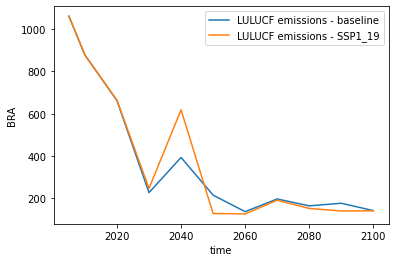

In [14]:
# comparison of gross emissions between 1_19 and 1_26 BRA
sns.lineplot(x = ems_lulucf_base.columns, y = ems_lulucf_base.loc["BRA",:], label = "LULUCF emissions - baseline")
sns.lineplot(x = ems_lulucf_19.columns, y = ems_lulucf_19.loc["BRA",:], label = "LULUCF emissions - SSP1_19")

<AxesSubplot:xlabel='time', ylabel='BRA'>

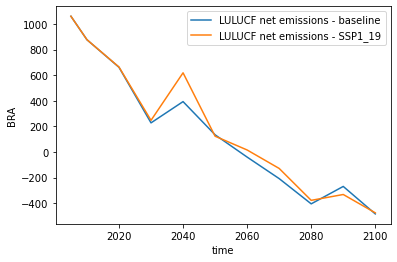

In [15]:
# comparison of net emissions between 1_19 and 1_26 BRA
sns.lineplot(x = netemis_tab_baseline.columns, y = netemis_tab_baseline.loc["BRA",:], label = "LULUCF net emissions - baseline")
sns.lineplot(x = netemis_tab.columns, y = netemis_tab.loc["BRA",:], label = "LULUCF net emissions - SSP1_19")

## Processing the low biomass scenario (SSP1_SPA0_19I_LIRE_LB), Brazil

In [3]:
# importing dataset in xlsx format
file_tab = "/Users/firzariany/Box/Climate Policy Team/04 - Modelling_and_Data/Datasets/IMAGE_2021/Release_June2021/SSP1_SPA0_19I_LIRE_LB.xlsx"

df_tab = pd.read_excel(file_tab, sheet_name="data")

In [4]:
# df_tab.Variable.unique()

In [5]:
# checking the evolution of different ems and seq variables within the scenario
vars_to_use = ['Emissions|CO2|AFOLU', 'Emissions|CO2|AFOLU|Land',
               'Carbon Sequestration|Land Use',
               'Carbon Sequestration|Land Use|Afforestation']

check_all = timeseries_df(paste_regions=["BRA"], paste_vars=vars_to_use, df_input_raw=df_tab)

In [6]:
check_all.Variable.unique()

array(['Carbon Sequestration|Land Use',
       'Carbon Sequestration|Land Use|Afforestation',
       'Emissions|CO2|AFOLU', 'Emissions|CO2|AFOLU|Land'], dtype=object)

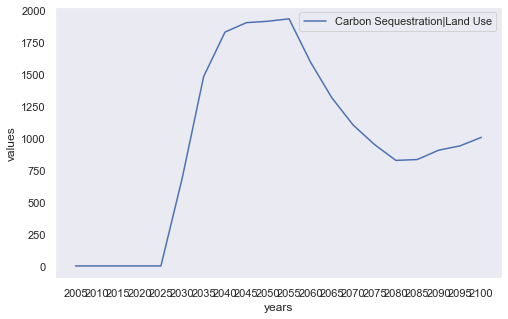

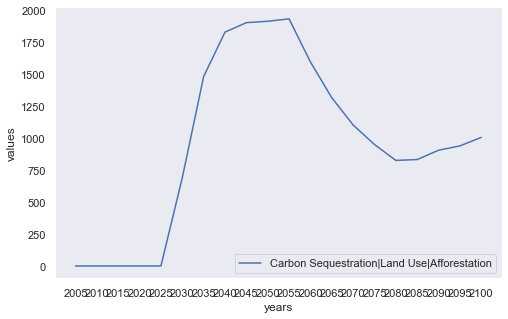

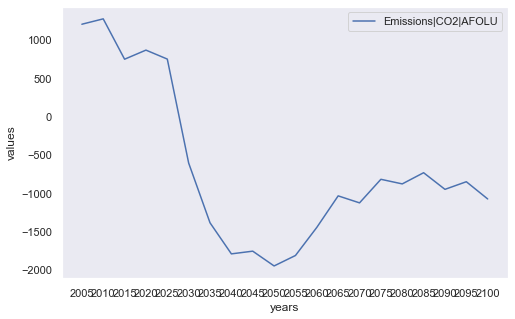

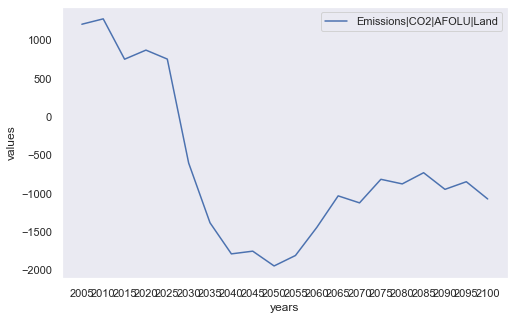

In [18]:
for x in check_all.Variable.unique():
    temp = check_all.loc[check_all.Variable == x]
    
    plt.figure(figsize=[8,5])
    sns.lineplot(data=temp, x="years", y="values", label=x)

In [8]:
# tidying the dataframe
long_df_bra = timeseries_df(paste_regions=["BRA"], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)

In [9]:
long_df_bra.columns

Index(['Region', 'Model', 'Scenario', 'Variable', 'Unit', 'years', 'values'], dtype='object')

In [10]:
long_df_bra.Variable.unique()

array(['Carbon Sequestration|Land Use', 'Emissions|CO2|AFOLU|Land'],
      dtype=object)

In [11]:
# subsetting the long dataframe
netemis_tab_july = long_df_bra.loc[long_df_bra.Variable == "Emissions|CO2|AFOLU|Land"]
seq_tab_july = long_df_bra.loc[long_df_bra.Variable == "Carbon Sequestration|Land Use"]

# convert the data type of the "years" column
netemis_tab_july.loc[:,"years"] = netemis_tab_july["years"].astype(int)
seq_tab_july.loc[:,"years"] = seq_tab_july["years"].astype(int)

/Users/firzariany/opt/anaconda3/envs/land_1o5_2/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Comparison of net emission between SSP1_19 old version, baseline, and SSP1_19 low biomass scenario

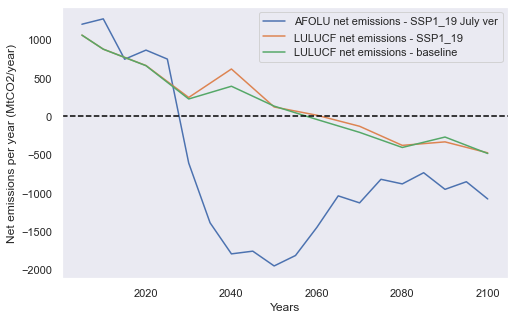

In [25]:
plt.figure(figsize=[8,5])
sns.set_theme(style="dark")
sns.lineplot(data=netemis_tab_july, x="years", y="values", label="AFOLU net emissions - SSP1_19 July ver") # low biomass, more land for forests
sns.lineplot(x = netemis_tab.columns, y = netemis_tab.loc["BRA",:], label = "LULUCF net emissions - SSP1_19")
sns.lineplot(x = netemis_tab_baseline.columns, y = netemis_tab_baseline.loc["BRA",:], label = "LULUCF net emissions - baseline")
plt.xlabel("Years", fontsize=12)
plt.ylabel("Net emissions per year (MtCO2/year)", fontsize=12)
plt.axhline(0, ls='--', c="black");

## Comparison of sequestration between SSP1_19 old version, baseline, and SSP1_19 low biomass scenario

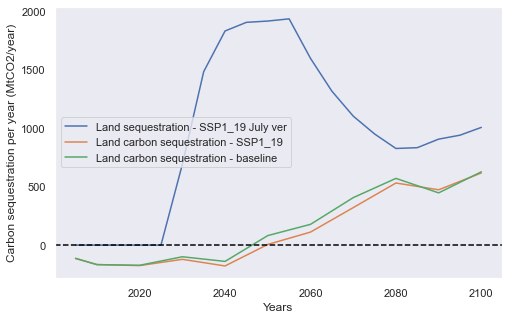

In [26]:
plt.figure(figsize=[8,5])
sns.lineplot(data=seq_tab_july, x="years", y="values", label="Land sequestration - SSP1_19 July ver")
sns.lineplot(x = seq_tab.columns, y = seq_tab.loc["BRA",:], label = "Land carbon sequestration - SSP1_19")
sns.lineplot(x = seq_tab_baseline.columns, y = seq_tab_baseline.loc["BRA",:], label = "Land carbon sequestration - baseline")
plt.xlabel("Years", fontsize=12)
plt.ylabel("Carbon sequestration per year (MtCO2/year)", fontsize=12)
plt.axhline(0, ls='--', c="black");

To find out what happens in the net emissions of scenario SSP1_SPA0_19I_LIRE_LB so that it causes the jagged line at the end of the century.

**Carbon sequestration**
In the old version of SSP1_19, the sequestration variable "Emissions|CO2|Land_Use|Carbon_Sequestration" was used. It includes carbon sequestration on managed land, negative and positive. As mentioned above, negative sequestration is due to forest degradation and climate effects of land. Similar definition perhaps applies to the old version of baseline SSP1_26? 

However, under scenario SSP1_SPA0_19I_LIRE_LB released in July 2021, carbon sequestration ("Carbon Sequestration|Land Use") defines total carbon dioxide sequestered through land-based sinks (e.g., afforestation, soil carbon enhancement, biochar). So I imagine that they do not account for forest degradation anymore? No climate change impacts?

Furthermore, under scenario SSP1_SPA0_19I_LIRE_LB, there are two variable names for sequestration: 'Carbon Sequestration|Land Use' and 'Carbon Sequestration|Land Use|Afforestation' which are the same (when plotted). These variables do not contain the emissions from forest degradation anymore. The model only accounts afforestation/forest regrowth as the sole driver for sequestration. 

**Net emissions**
In the old version of SSP1_19, the net emission variable "Emissions|CO2|Land_Use" was used. It is a total net land use change emissions and sequestration (it includes all the emissions from land use change and forestry). 

Under scenario SSP1_SPA0_19I_LIRE_LB, net emission is included in "Emissions|CO2|AFOLU|Land" which is a net CO2|AFOL emissions and sequestration from forestry and other land use. The most important driver for emission is land use expansion and thus the combination of food, bio-energy demand, and yield improvement. Food demand is in turn driven by population and income. 

Under scenario SSP1_SPA0_19I_LIRE_LB includes a net CO2|AFOL emissions and sequestration from forestry and other land use (and land use change?). It follows the same principle, when positive emissions >> sequestration, and when negative emissions << sequestration. 

But in Brazil, there seems to be some fluctuations in net emissions that kind of bringing back the net negative emissions to positive values while sequestration is decreasing at the end of the century. What can be the reason? The reason should depend on the scenario used. In this case, SSP1_SPA0_19I_LIRE_LB: sustainability green pathway without mitigation targets, with low biomass, and high renewable energy input.

---

## Separating emissions and sequestration under the low biomass scenario (SSP1_SPA0_19I_LIRE_LB), Brazil

In [12]:
def pure_emis(df_input_long, vars_label, give_seq_vars, give_netemis_vars):
    ts_df_seq = df_input_long.loc[df_input_long[vars_label] == give_seq_vars] # get the sequestration data
    ts_df_netemis = df_input_long.loc[df_input_long[vars_label] == give_netemis_vars] # get the net emission data
    
    ts_vals_ems = [] # a new list to store pure emissions
    
    # pipeline to separate emission and sequestration
    for x, y in zip(ts_df_netemis["values"], ts_df_seq["values"]):
        ts_vals_ems.append(x + (y)) 
        
    # store the results in a dataframe 
    ts_df_emis = pd.DataFrame({"Region" : ts_df_netemis.Region, 
                               "Model": ts_df_netemis.Model, 
                               "Scenario" : ts_df_netemis.Scenario,
                               "Variable" : "Pure_Emissions|CO2|AFOLU|Land", 
                               "Unit" : ts_df_netemis.Unit,
                               "years" : ts_df_netemis.years, 
                               "values" : ts_vals_ems})
    
    # add the results to the input dataframe
    new_df = pd.concat([df_input_long, ts_df_emis]).sort_values(by=["years"])
        
    return new_df

In [13]:
new_long_bra = pure_emis(df_input_long=long_df_bra, vars_label='Variable', 
                         give_seq_vars="Carbon Sequestration|Land Use", give_netemis_vars="Emissions|CO2|AFOLU|Land")

In [14]:
new_long_bra.Variable.unique()

array(['Carbon Sequestration|Land Use', 'Emissions|CO2|AFOLU|Land',
       'Pure_Emissions|CO2|AFOLU|Land'], dtype=object)

In [15]:
def plt_ems_profile(df_netemis, df_seq, df_ems):
    plt.figure(figsize=[8,5])
    sns.lineplot(data=df_netemis, x="years", y="values", label="Net Emissions (Mt CO2/yr)")
    sns.lineplot(data=df_seq, x="years", y="values", label="Sequestration (Mt CO2/yr)")
    sns.lineplot(data=df_ems, x="years", y="values", label="Emissions (Mt CO2/yr)")
    plt.xticks(np.arange(0, len(df_netemis.years.unique())+1, 2))
    plt.xlabel("Years", fontsize=12)
    plt.ylabel("MtCO2/year", fontsize=12)
    plt.axhline(0, ls='--', c="black");

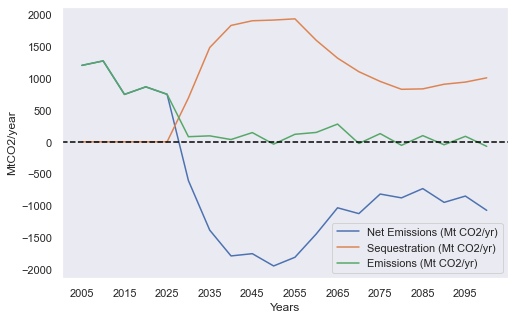

In [19]:
# plotting pure sequestration, pure emissions, and net emissions
ts_df_netemis = new_long_bra.loc[new_long_bra.Variable == "Emissions|CO2|AFOLU|Land"]
ts_df_seq = new_long_bra.loc[new_long_bra.Variable == "Carbon Sequestration|Land Use"]
ts_df_emis = new_long_bra.loc[new_long_bra.Variable == "Pure_Emissions|CO2|AFOLU|Land"]

plt_ems_profile(df_netemis=ts_df_netemis, df_seq=ts_df_seq, df_ems=ts_df_emis)

---
## Land use pattern, Brazil

### All land use 

In [128]:
# land variables to use
land_vars = ["Land Cover|Built-up Area",
            "Land Cover|Cropland", "Land Cover|Forest",
            "Land Cover|Other Arable Land", "Land Cover|Other Land",
            "Land Cover|Pasture"]

# tidy dataframe, from wide to long
lu_pattern_bra = timeseries_df(paste_regions=["BRA"], paste_vars=land_vars, df_input_raw=df_tab, variable_colnames=True)

In [21]:
lu_pattern_bra.head()

Region  Model               Scenario           Variable        Unit years  \
0    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB      Built-up Area  million ha  2005   
1    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB           Cropland  million ha  2005   
2    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB             Forest  million ha  2005   
3    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Other Arable Land  million ha  2005   
4    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB         Other Land  million ha  2005   

       values  
0    2.534667  
1   76.460219  
2  409.224825  
3  159.034388  
4    0.000000

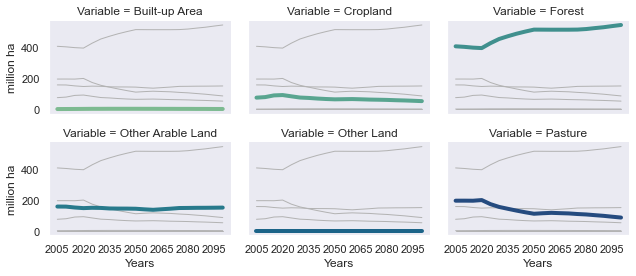

In [22]:
# individual evolution
timeseries_pattern(df_input_long=lu_pattern_bra, give_x='years', give_y='values', vars_label='Variable')

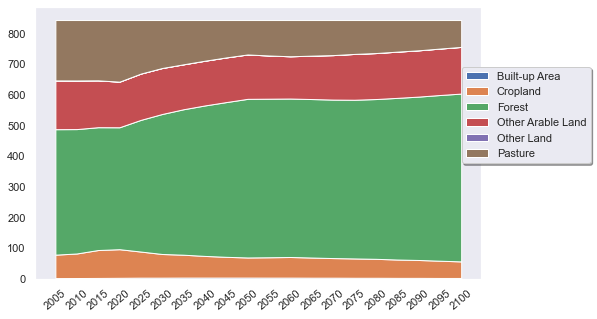

In [23]:
# stacked evolution, to see the dominant
stackplot_pattern(df_input_long=lu_pattern_bra, year_label='years', vars_label='Variable', values_label='values')

### Cropland

In [133]:
crop_land = ["Land Cover|Cropland"]

crop_bra = timeseries_df(paste_regions=["BRA"], paste_vars=crop_land, df_input_raw=df_tab, variable_colnames=True)

<Figure size 1080x360 with 0 Axes>

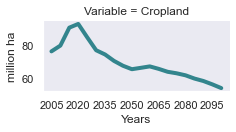

In [134]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=crop_bra, give_x='years', give_y='values', vars_label='Variable')

### Bioenergy crops

In [136]:
bioenergy_crops = ['Land Cover|Cropland|Energy Crops']

biocrop_bra = timeseries_df(paste_regions=["BRA"], paste_vars=bioenergy_crops, df_input_raw=df_tab, variable_colnames=True)

In [137]:
biocrop_bra.head()

Region  Model               Scenario      Variable        Unit years  \
0    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Energy Crops  million ha  2005   
1    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Energy Crops  million ha  2010   
2    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Energy Crops  million ha  2015   
3    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Energy Crops  million ha  2020   
4    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Energy Crops  million ha  2025   

     values  
0  0.609620  
1  1.083535  
2  2.599413  
3  3.783059  
4  4.519702

<Figure size 1080x360 with 0 Axes>

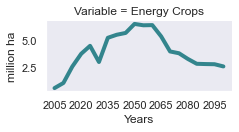

In [138]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=biocrop_bra, give_x='years', give_y='values', vars_label='Variable')

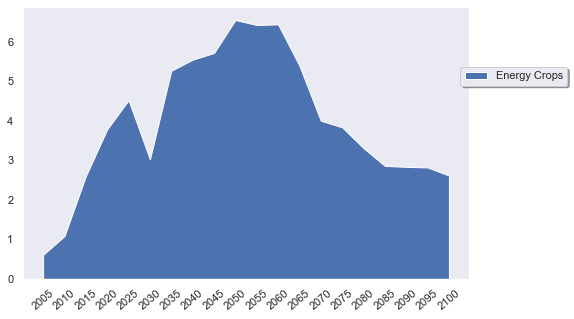

In [139]:
stackplot_pattern(df_input_long=biocrop_bra, year_label='years', vars_label='Variable', values_label='values')

### Forest land

In [25]:
forest_land = ['Land Cover|Forest|Afforestation and Reforestation', 'Land Cover|Forest|Forestry|Harvested Area',
              'Land Cover|Forest|Managed', 'Land Cover|Forest|Natural Forest']

forest_bra = timeseries_df(paste_regions=["BRA"], paste_vars=forest_land, df_input_raw=df_tab, variable_colnames=True)

In [26]:
forest_bra.head()

Region  Model               Scenario                         Variable  \
0    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Afforestation and Reforestation   
1    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB                   Harvested Area   
2    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB                          Managed   
3    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB                   Natural Forest   
4    BRA  IMAGE  SSP1_SPA0_19I_LIRE_LB  Afforestation and Reforestation   

         Unit years      values  
0  million ha  2005    0.000000  
1  million ha  2005   13.652777  
2  million ha  2005   11.921688  
3  million ha  2005  397.303100  
4  million ha  2010    0.000000

<Figure size 1080x360 with 0 Axes>

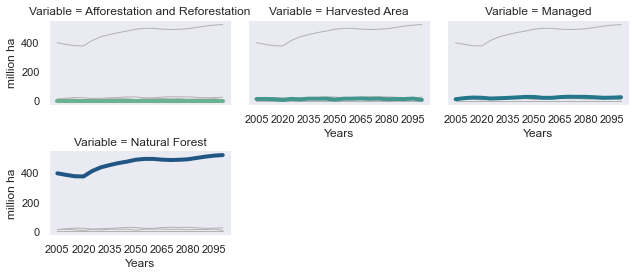

In [27]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=forest_bra, give_x='years', give_y='values', vars_label='Variable')

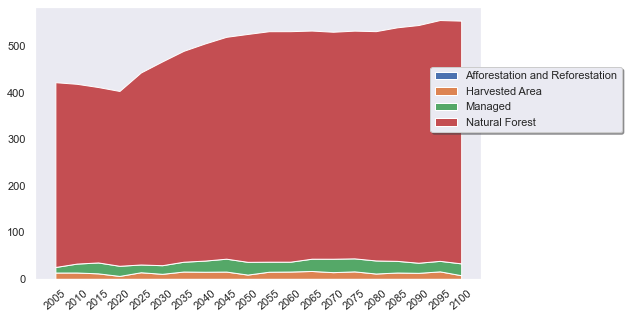

In [28]:
stackplot_pattern(df_input_long=forest_bra, year_label='years', vars_label='Variable', values_label='values')

# Western Africa

## Emissions, sequestration

In [31]:
long_df_waf = timeseries_df(paste_regions=['WAF'], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)

In [32]:
long_df_waf.head()

Region  Model               Scenario                       Variable  \
0    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
1    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
2    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
3    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
4    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   

        Unit years      values  
0  Mt CO2/yr  2005   -0.000000  
1  Mt CO2/yr  2005  487.710136  
2  Mt CO2/yr  2010   -0.000000  
3  Mt CO2/yr  2010  537.507406  
4  Mt CO2/yr  2015   -0.000000

In [33]:
new_long_waf = pure_emis(df_input_long=long_df_waf, vars_label='Variable', give_seq_vars='Carbon Sequestration|Land Use', 
                         give_netemis_vars='Emissions|CO2|AFOLU|Land')

In [34]:
new_long_waf.Variable.unique()

array(['Carbon Sequestration|Land Use', 'Emissions|CO2|AFOLU|Land',
       'Pure_Emissions|CO2|AFOLU|Land'], dtype=object)

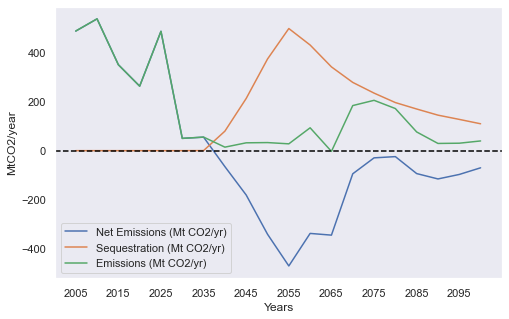

In [35]:
# plotting pure sequestration, pure emissions, and net emissions
ts_waf_netemis = new_long_waf.loc[new_long_waf.Variable == "Emissions|CO2|AFOLU|Land"]
ts_waf_seq = new_long_waf.loc[new_long_waf.Variable == "Carbon Sequestration|Land Use"]
ts_waf_emis = new_long_waf.loc[new_long_waf.Variable == "Pure_Emissions|CO2|AFOLU|Land"]

plt_ems_profile(df_netemis=ts_waf_netemis, df_seq=ts_waf_seq, df_ems=ts_waf_emis)

## All land use

In [36]:
# land_vars
lu_pattern_waf = timeseries_df(paste_regions=["WAF"], paste_vars=land_vars, df_input_raw=df_tab, variable_colnames=True)

In [37]:
lu_pattern_waf.head()

Region  Model               Scenario           Variable        Unit years  \
0    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB      Built-up Area  million ha  2005   
1    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB           Cropland  million ha  2005   
2    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB             Forest  million ha  2005   
3    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB  Other Arable Land  million ha  2005   
4    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB         Other Land  million ha  2005   

       values  
0    1.636623  
1  118.756512  
2  254.726925  
3  213.723925  
4  280.013325

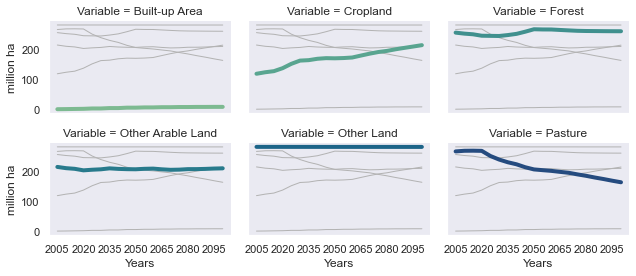

In [38]:
timeseries_pattern(df_input_long=lu_pattern_waf, give_x='years', give_y='values', vars_label='Variable')

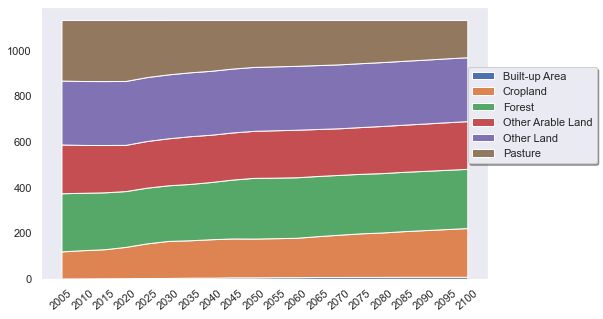

In [39]:
stackplot_pattern(df_input_long=lu_pattern_waf, year_label='years', vars_label='Variable', values_label='values')

## Cropland

In [40]:
crop_land = ["Land Cover|Cropland"]

crop_waf = timeseries_df(paste_regions=["WAF"], paste_vars=crop_land, df_input_raw=df_tab, variable_colnames=True)

<Figure size 1080x360 with 0 Axes>

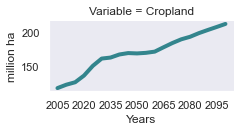

In [41]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=crop_waf, give_x='years', give_y='values', vars_label='Variable')

## Bioenergy crops

In [46]:
# bioenergy_crops
biocrop_waf = timeseries_df(paste_regions=["WAF"], paste_vars=["Land Cover|Cropland|Energy Crops"], df_input_raw=df_tab, variable_colnames=True)

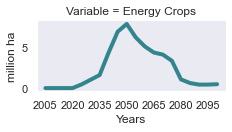

In [47]:
timeseries_pattern(df_input_long=biocrop_waf, give_x='years', give_y='values', vars_label='Variable')

## Forest land

In [50]:
# forest_land
forest_waf = timeseries_df(paste_regions=["WAF"], paste_vars=forest_land, df_input_raw=df_tab, variable_colnames=True)

In [51]:
forest_waf.head()

Region  Model               Scenario                         Variable  \
0    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB  Afforestation and Reforestation   
1    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB                   Harvested Area   
2    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB                          Managed   
3    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB                   Natural Forest   
4    WAF  IMAGE  SSP1_SPA0_19I_LIRE_LB  Afforestation and Reforestation   

         Unit years      values  
0  million ha  2005    0.000000  
1  million ha  2005   13.393227  
2  million ha  2005   15.989306  
3  million ha  2005  238.737600  
4  million ha  2010    0.000000

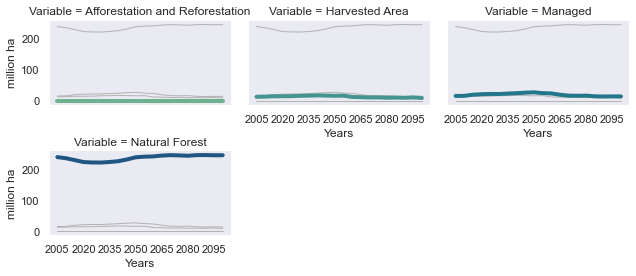

In [52]:
timeseries_pattern(df_input_long=forest_waf, give_x='years', give_y='values', vars_label='Variable')

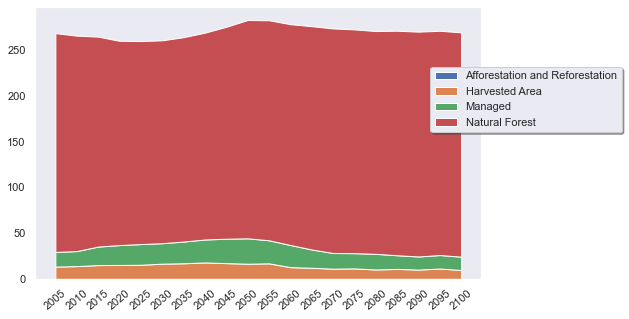

In [53]:
stackplot_pattern(df_input_long=forest_waf, year_label='years', vars_label='Variable', values_label='values')

# Indonesia

## Emissions, sequestration

In [25]:
# df_raw = df_tab

In [56]:
long_df_indo = timeseries_df(paste_regions=['INDO'], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], 
                             df_input_raw=df_tab)

In [57]:
long_df_indo.head()

Region  Model               Scenario                       Variable  \
0   INDO  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
1   INDO  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
2   INDO  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
3   INDO  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
4   INDO  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   

        Unit years       values  
0  Mt CO2/yr  2005    -0.000000  
1  Mt CO2/yr  2005  1053.835209  
2  Mt CO2/yr  2010    -0.000000  
3  Mt CO2/yr  2010  1108.408224  
4  Mt CO2/yr  2015    -0.000000

In [58]:
new_long_indo = pure_emis(df_input_long=long_df_indo, vars_label='Variable', 
                          give_seq_vars='Carbon Sequestration|Land Use', give_netemis_vars='Emissions|CO2|AFOLU|Land')

In [59]:
new_long_indo.Variable.unique()

array(['Carbon Sequestration|Land Use', 'Emissions|CO2|AFOLU|Land',
       'Pure_Emissions|CO2|AFOLU|Land'], dtype=object)

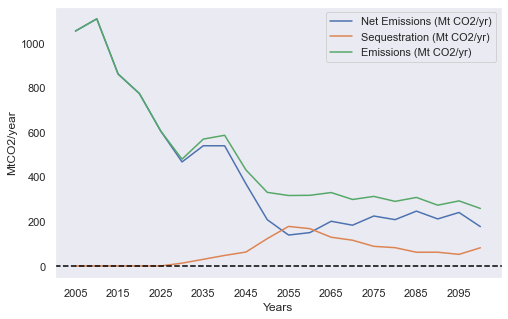

In [60]:
# plotting pure sequestration, pure emissions, and net emissions
ts_indo_netemis = new_long_indo.loc[new_long_indo.Variable == "Emissions|CO2|AFOLU|Land"]
ts_indo_seq = new_long_indo.loc[new_long_indo.Variable == "Carbon Sequestration|Land Use"]
ts_indo_emis = new_long_indo.loc[new_long_indo.Variable == "Pure_Emissions|CO2|AFOLU|Land"]

plt_ems_profile(df_netemis=ts_indo_netemis, df_seq=ts_indo_seq, df_ems=ts_indo_emis)

## All land use

In [65]:
df_tab.Region.unique()

array(['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR',
       'ME', 'MEX', 'NAF', 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS',
       'SAF', 'SEAS', 'STAN', 'TUR', 'UKR', 'USA', 'WAF', 'WEU', 'World'],
      dtype=object)

In [66]:
# land_vars
lu_pattern_indo = timeseries_df(paste_regions=["INDO"], paste_vars=land_vars, df_input_raw=df_tab, variable_colnames=True)

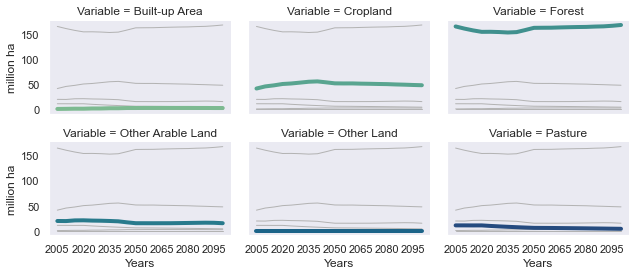

In [67]:
timeseries_pattern(df_input_long=lu_pattern_indo, give_x='years', give_y='values', vars_label='Variable')

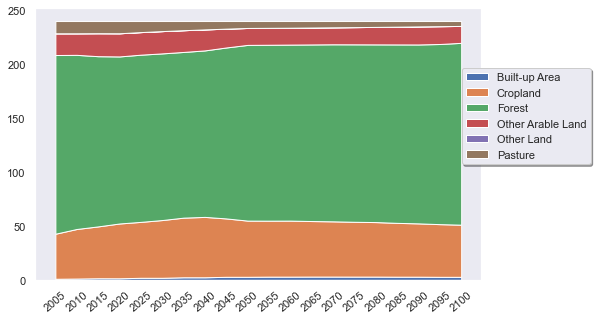

In [68]:
stackplot_pattern(df_input_long=lu_pattern_indo, year_label='years', vars_label='Variable', values_label='values')

## Cropland

In [69]:
crop_indo = timeseries_df(paste_regions=["INDO"], paste_vars=crop_land, df_input_raw=df_tab, variable_colnames=True)

<Figure size 1080x360 with 0 Axes>

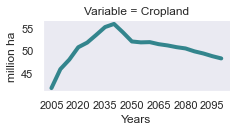

In [70]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=crop_indo, give_x='years', give_y='values', vars_label='Variable')

## Bioenergy crops 

In [71]:
# bioenergy_crops
biocrop_indo = timeseries_df(paste_regions=["INDO"], paste_vars=["Land Cover|Cropland|Energy Crops"], df_input_raw=df_tab, variable_colnames=True)

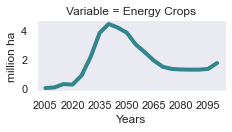

In [72]:
timeseries_pattern(df_input_long=biocrop_indo, give_x='years', give_y='values', vars_label='Variable')

## Forest land

In [73]:
# forest_land
forest_indo = timeseries_df(paste_regions=['INDO'], paste_vars=forest_land, df_input_raw=df_tab, variable_colnames=True)

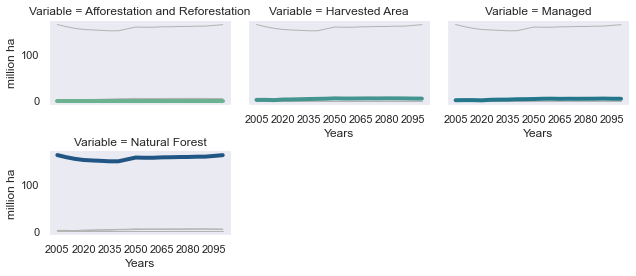

In [74]:
timeseries_pattern(df_input_long=forest_indo, give_x='years', give_y='values', vars_label='Variable')

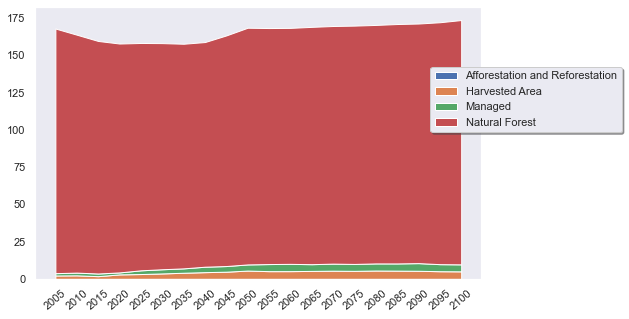

In [75]:
stackplot_pattern(df_input_long=forest_indo, year_label='years', vars_label='Variable', values_label='values')

# China region

## Emissions, sequestration

In [76]:
long_df_chn = timeseries_df(paste_regions=['CHN'], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)


In [77]:
long_df_chn.head()

Region  Model               Scenario                       Variable  \
0    CHN  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
1    CHN  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
2    CHN  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
3    CHN  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
4    CHN  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   

        Unit years      values  
0  Mt CO2/yr  2005   -0.000000  
1  Mt CO2/yr  2005  209.902194  
2  Mt CO2/yr  2010   -0.000000  
3  Mt CO2/yr  2010  141.601318  
4  Mt CO2/yr  2015   -0.000000

In [78]:
new_long_chn = pure_emis(df_input_long=long_df_chn, vars_label='Variable',
                         give_seq_vars='Carbon Sequestration|Land Use', give_netemis_vars='Emissions|CO2|AFOLU|Land')

In [79]:
new_long_chn.Variable.unique()

array(['Carbon Sequestration|Land Use', 'Emissions|CO2|AFOLU|Land',
       'Pure_Emissions|CO2|AFOLU|Land'], dtype=object)

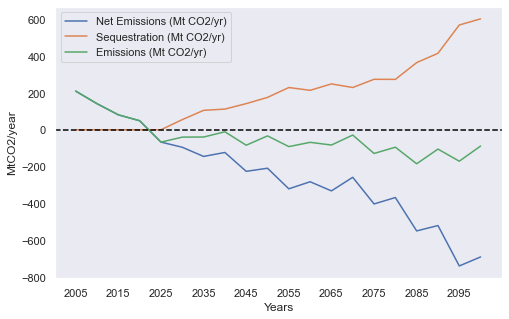

In [80]:
# plotting pure sequestration, pure emissions, and net emissions
ts_chn_netemis = new_long_chn.loc[new_long_chn.Variable == "Emissions|CO2|AFOLU|Land"]
ts_chn_seq = new_long_chn.loc[new_long_chn.Variable == "Carbon Sequestration|Land Use"]
ts_chn_emis = new_long_chn.loc[new_long_chn.Variable == "Pure_Emissions|CO2|AFOLU|Land"]

plt_ems_profile(df_netemis=ts_chn_netemis, df_seq=ts_chn_seq, df_ems=ts_chn_emis)

## All land use

In [81]:
# land_vars
lu_pattern_chn = timeseries_df(paste_regions=['CHN'], paste_vars=land_vars, df_input_raw=df_tab, variable_colnames=True)

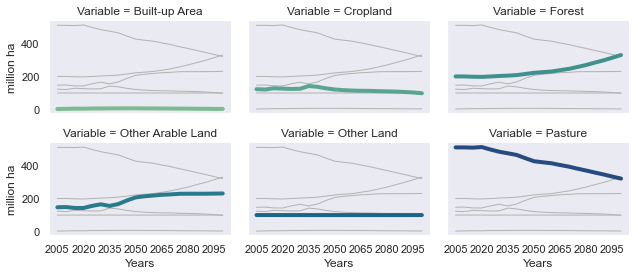

In [82]:
timeseries_pattern(df_input_long=lu_pattern_chn, give_x='years', give_y='values', vars_label='Variable')

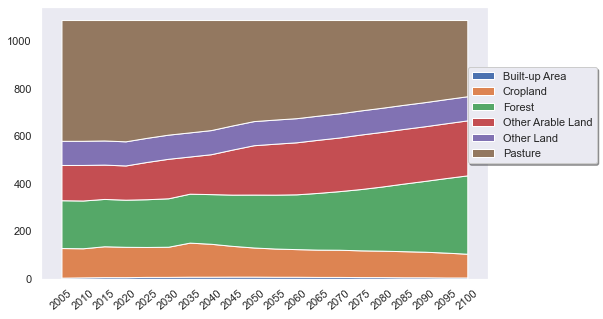

In [83]:
stackplot_pattern(df_input_long=lu_pattern_chn, year_label='years', vars_label='Variable', values_label='values')

## Cropland

In [84]:
crop_chn = timeseries_df(paste_regions=["CHN"], paste_vars=crop_land, df_input_raw=df_tab, variable_colnames=True)

<Figure size 1080x360 with 0 Axes>

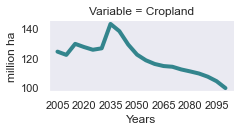

In [85]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=crop_chn, give_x='years', give_y='values', vars_label='Variable')

## Bioenergy crops 

In [86]:
# bioenergy_crops
biocrop_chn = timeseries_df(paste_regions=["CHN"], paste_vars=["Land Cover|Cropland|Energy Crops"], df_input_raw=df_tab, variable_colnames=True)

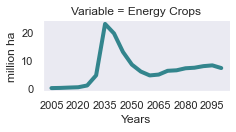

In [87]:
timeseries_pattern(df_input_long=biocrop_chn, give_x='years', give_y='values', vars_label='Variable')

## Forest land 

In [90]:
# forest_land
forest_chn = timeseries_df(paste_regions=['CHN'], paste_vars=forest_land, df_input_raw=df_tab, variable_colnames=True)


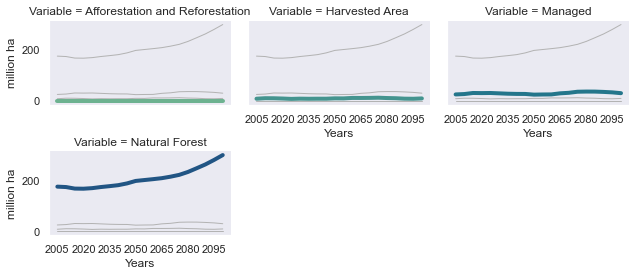

In [91]:
timeseries_pattern(df_input_long=forest_chn, give_x='years', give_y='values', vars_label='Variable')

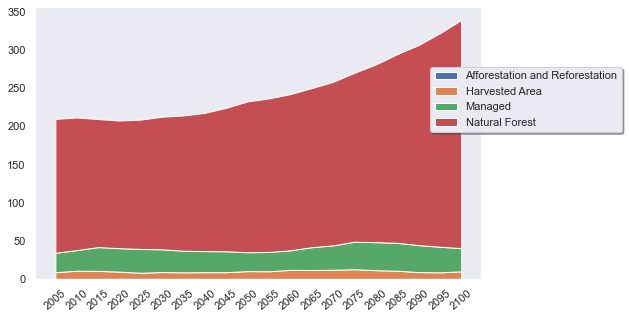

In [92]:
stackplot_pattern(df_input_long=forest_chn, year_label='years', vars_label='Variable', values_label='values')

# Oceania, incl. Australia

## Emissions, sequestration

In [93]:
long_df_oce = timeseries_df(paste_regions=['OCE'], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)


In [94]:
long_df_oce.head()

Region  Model               Scenario                       Variable  \
0    OCE  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
1    OCE  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
2    OCE  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
3    OCE  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
4    OCE  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   

        Unit years     values  
0  Mt CO2/yr  2005  -0.000000  
1  Mt CO2/yr  2005  18.762739  
2  Mt CO2/yr  2010  -0.000000  
3  Mt CO2/yr  2010  71.909025  
4  Mt CO2/yr  2015  -0.000000

In [95]:
new_long_oce = pure_emis(df_input_long=long_df_oce, vars_label='Variable',
                         give_seq_vars='Carbon Sequestration|Land Use', give_netemis_vars='Emissions|CO2|AFOLU|Land')

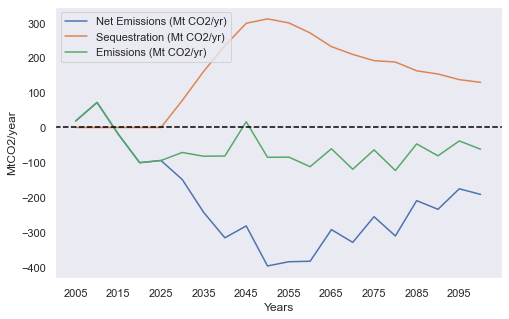

In [96]:
# plotting pure sequestration, pure emissions, and net emissions
ts_oce_netemis = new_long_oce.loc[new_long_oce.Variable == "Emissions|CO2|AFOLU|Land"]
ts_oce_seq = new_long_oce.loc[new_long_oce.Variable == "Carbon Sequestration|Land Use"]
ts_oce_emis = new_long_oce.loc[new_long_oce.Variable == "Pure_Emissions|CO2|AFOLU|Land"]

plt_ems_profile(df_netemis=ts_oce_netemis, df_seq=ts_oce_seq, df_ems=ts_oce_emis)

## All land use

In [97]:
# land_vars
lu_pattern_oce = timeseries_df(paste_regions=['OCE'], paste_vars=land_vars, df_input_raw=df_tab, variable_colnames=True)


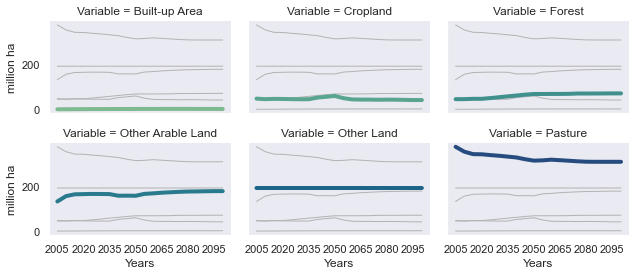

In [98]:
timeseries_pattern(df_input_long=lu_pattern_oce, give_x='years', give_y='values', vars_label='Variable')


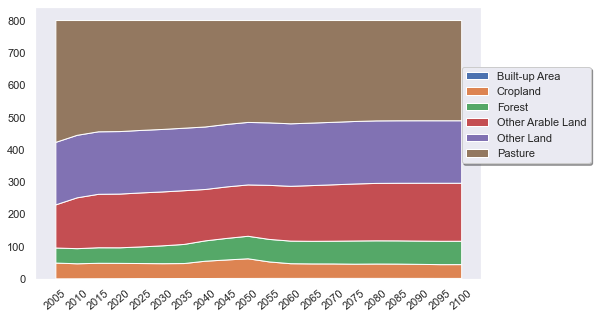

In [99]:
stackplot_pattern(df_input_long=lu_pattern_oce, year_label='years', vars_label='Variable', values_label='values')


## Cropland

In [103]:
crop_oce = timeseries_df(paste_regions=["OCE"], paste_vars=crop_land, df_input_raw=df_tab, variable_colnames=True)

<Figure size 1080x360 with 0 Axes>

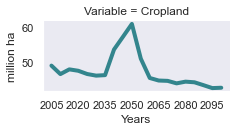

In [104]:
plt.figure(figsize=[15,5])
timeseries_pattern(df_input_long=crop_oce, give_x='years', give_y='values', vars_label='Variable')

## Bioenergy crops

In [101]:
# bioenergy_crops
biocrop_oce = timeseries_df(paste_regions=['OCE'], paste_vars=["Land Cover|Cropland|Energy Crops"], df_input_raw=df_tab, variable_colnames=True)

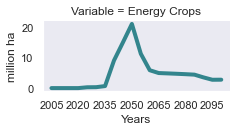

In [102]:
timeseries_pattern(df_input_long=biocrop_oce, give_x='years', give_y='values', vars_label='Variable')


## Forest land 

In [105]:
# forest_land
forest_oce = timeseries_df(paste_regions=['OCE'], paste_vars=forest_land, df_input_raw=df_tab, variable_colnames=True)

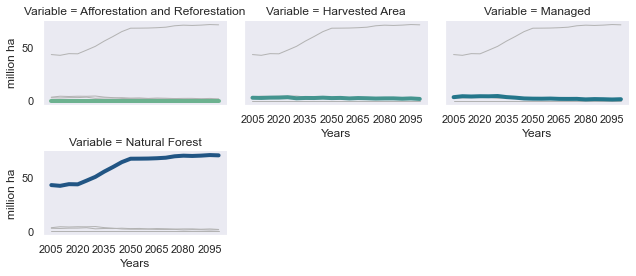

In [106]:
timeseries_pattern(df_input_long=forest_oce, give_x='years', give_y='values', vars_label='Variable')


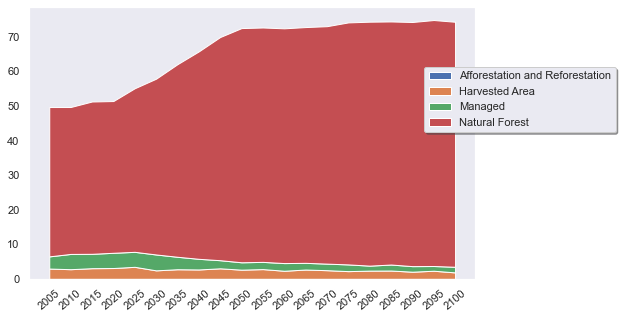

In [107]:
stackplot_pattern(df_input_long=forest_oce, year_label='years', vars_label='Variable', values_label='values')


# Rest of South America (excl. Brazil)

## Emissions, sequestration

In [108]:
long_df_rsam = timeseries_df(paste_regions=['RSAM'], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)


In [109]:
long_df_rsam.head()

Region  Model               Scenario                       Variable  \
0   RSAM  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
1   RSAM  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
2   RSAM  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   
3   RSAM  IMAGE  SSP1_SPA0_19I_LIRE_LB       Emissions|CO2|AFOLU|Land   
4   RSAM  IMAGE  SSP1_SPA0_19I_LIRE_LB  Carbon Sequestration|Land Use   

        Unit years      values  
0  Mt CO2/yr  2005   -0.000000  
1  Mt CO2/yr  2005   94.390039  
2  Mt CO2/yr  2010   -0.000000  
3  Mt CO2/yr  2010  729.298010  
4  Mt CO2/yr  2015   -0.000000

In [110]:
new_long_rsam = pure_emis(df_input_long=long_df_rsam, vars_label='Variable',
                          give_seq_vars='Carbon Sequestration|Land Use', give_netemis_vars='Emissions|CO2|AFOLU|Land')

In [111]:
new_long_rsam.Variable.unique()

array(['Carbon Sequestration|Land Use', 'Emissions|CO2|AFOLU|Land',
       'Pure_Emissions|CO2|AFOLU|Land'], dtype=object)

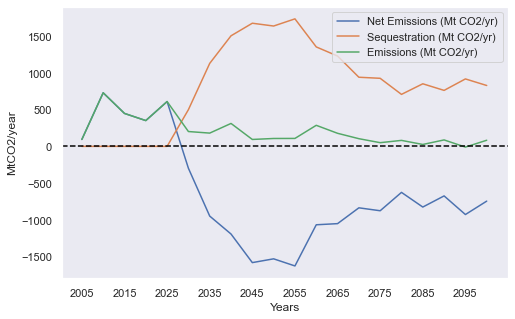

In [112]:
# plotting pure sequestration, pure emissions, and net emissions
ts_rsam_netemis = new_long_rsam.loc[new_long_rsam.Variable == "Emissions|CO2|AFOLU|Land"]
ts_rsam_seq = new_long_rsam.loc[new_long_rsam.Variable == "Carbon Sequestration|Land Use"]
ts_rsam_emis = new_long_rsam.loc[new_long_rsam.Variable == "Pure_Emissions|CO2|AFOLU|Land"]

plt_ems_profile(df_netemis=ts_rsam_netemis, df_seq=ts_rsam_seq, df_ems=ts_rsam_emis)

## All land use

In [113]:
# land_vars
lu_pattern_rsam = timeseries_df(paste_regions=['RSAM'], paste_vars=land_vars, df_input_raw=df_tab, variable_colnames=True)


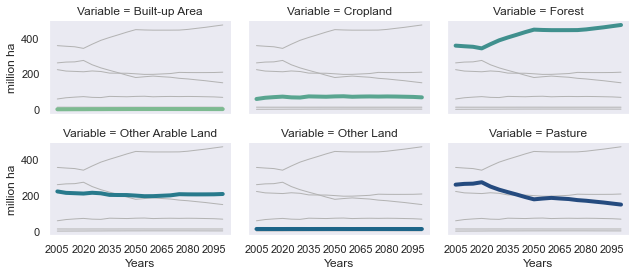

In [114]:
timeseries_pattern(df_input_long=lu_pattern_rsam, give_x='years', give_y='values', vars_label='Variable')


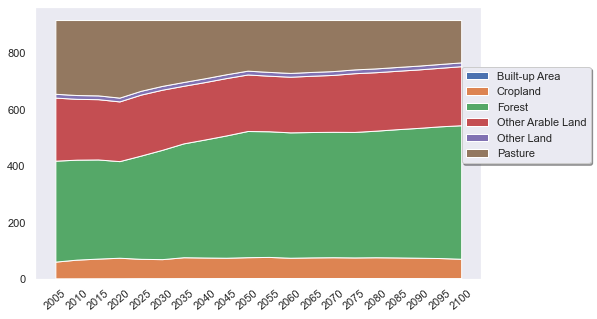

In [115]:
stackplot_pattern(df_input_long=lu_pattern_rsam, year_label='years', vars_label='Variable', values_label='values')


## Cropland

In [116]:
crop_rsam = timeseries_df(paste_regions=["RSAM"], paste_vars=crop_land, df_input_raw=df_tab, variable_colnames=True)

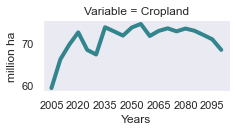

In [117]:
timeseries_pattern(df_input_long=crop_rsam, give_x='years', give_y='values', vars_label='Variable')


## Bioenergy crops

In [119]:
# bioenergy_crops
biocrop_rsam = timeseries_df(paste_regions=['RSAM'], paste_vars=["Land Cover|Cropland|Energy Crops"], df_input_raw=df_tab, variable_colnames=True)

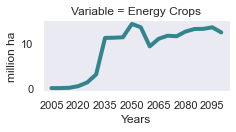

In [120]:
timeseries_pattern(df_input_long=biocrop_rsam, give_x='years', give_y='values', vars_label='Variable')


## Forest land

In [125]:
# forest_land
forest_rsam = timeseries_df(paste_regions=['RSAM'], paste_vars=forest_land, df_input_raw=df_tab, variable_colnames=True)

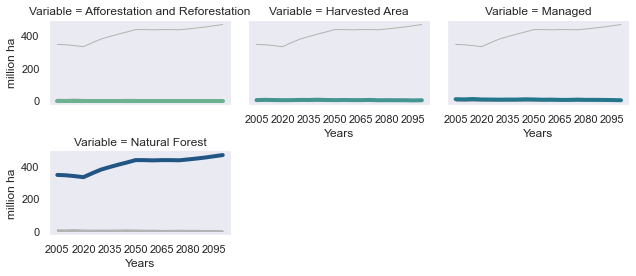

In [126]:
timeseries_pattern(df_input_long=forest_rsam, give_x='years', give_y='values', vars_label='Variable')


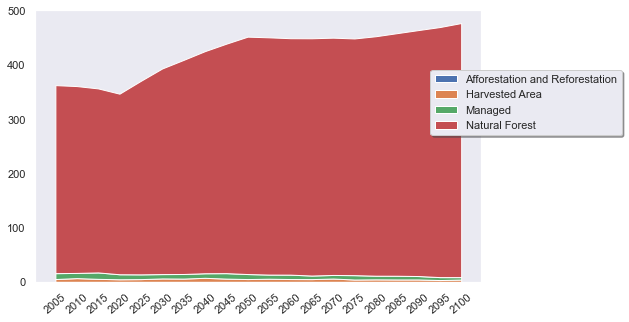

In [127]:
stackplot_pattern(df_input_long=forest_rsam, year_label='years', vars_label='Variable', values_label='values')
